In [296]:
import numpy as np
import pandas as pd
import os
import platform

# graphing
import matplotlib.image as mpimage
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image
import random
import gc
import re
import cv2

# TF model stuff
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


## Helper functions: Filesystem

In [297]:
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

## Helper Functions: Data Visu

In [298]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))
    
def visualize_epochs(hist):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']
    ylim_pad = [0.01, 0.1]
    plt.figure(figsize=(15, 5))
    # Plot training & validation Accuracy values
    y1 = hist.history['acc']
    y2 = hist.history['val_acc']
    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    
    plt.subplot(121)
    plt.plot(y1)
    plt.plot(y2)
    
    plt.title('Model Accuracy', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    
    # Plot training & validation loss values
    
    y1 = hist.history['loss']
    y2 = hist.history['val_loss']
    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    plt.subplot(122)
    plt.plot(y1)
    plt.plot(y2)
    
    plt.title('Model Loss', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
                         
    plt.show()
    
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

In [299]:
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
validation_dir = 'chest_xray/val'
output_dir = "data/output"
figure_directory = "data/output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)

file_name_pred_batch = figure_directory+"/result"
file_name_pred_sample = figure_directory+"/sample"

#### Use helper functions to display some of the training data.
- xrays of neumonia
- xrays of no infection

Number of Class:  2
-------------------------------------------------------Pneumonia-------------------------------------------------------


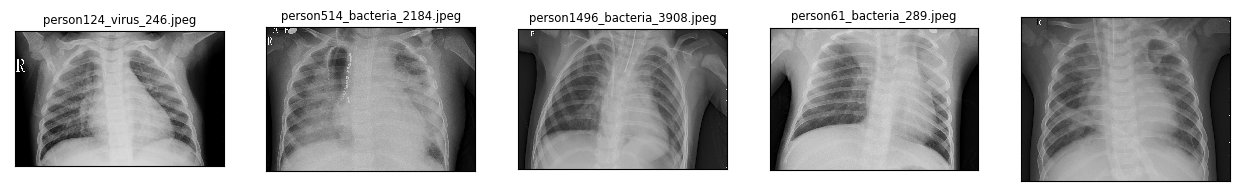


-------------------------------------------------------Normal-------------------------------------------------------


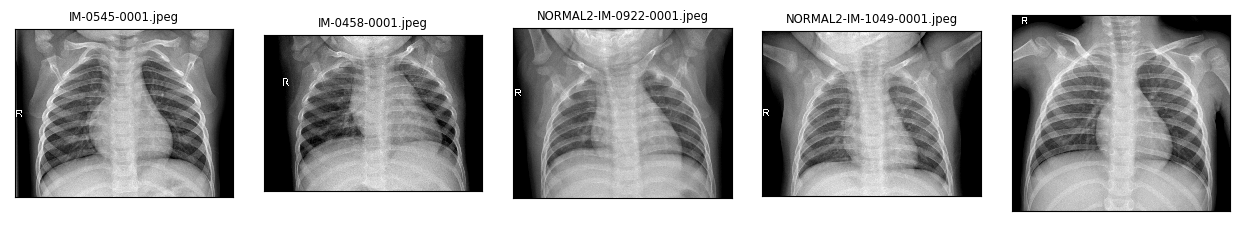


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [300]:
show_class_sample_images(train_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

## Build and Compile model using transfer learning

In [448]:
NUM_CLASSES = 2
def create_model(input_shape):
    K.clear_session()
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)


    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    for layer in base_model.layers:
        layer.trainable = False
        
    predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.inputs, outputs=predictions)

    return model

In [449]:
dimension_x = 150
dimension_y = 150
model = create_model((dimension_x, dimension_y, 3))

In [450]:
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy', dtype=tf.float32)
#model.summary()

In [458]:
optimizer = Adam(lr=0.015)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

## Preprocess image data

In [459]:
rescale = 1./255
target_size = (dimension_x, dimension_y)
larger batch size seems to perform bet
batch_size = 1000
class_mode = 'categorical'

train_datagen = ImageDataGenerator(rescale=rescale,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.2)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir,
                                               target_size=target_size,
                                               class_mode=class_mode,
                                               batch_size=dir_file_count(validation_dir),
                                               shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [460]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


## Training

In [461]:
# Less epochs will prevent overfitting
epochs = 5
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)
history = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              class_weight=train_class_weights,
                              workers=20
                             )
MODEL_FILE = 'pneumonia_v1.hd5'
model.save(MODEL_FILE)

Epoch 1/5
6/6 [==============================] - 98s 16s/step - loss: 0.2306 - acc: 0.9139 - val_loss: 1.2535 - val_acc: 0.5000
Epoch 2/5
6/6 [==============================] - 85s 14s/step - loss: 0.1894 - acc: 0.9247 - val_loss: 3.6183 - val_acc: 0.5000
Epoch 3/5
6/6 [==============================] - 88s 15s/step - loss: 0.1935 - acc: 0.9233 - val_loss: 4.1031 - val_acc: 0.5625
Epoch 4/5
6/6 [==============================] - 88s 15s/step - loss: 0.1955 - acc: 0.9225 - val_loss: 2.2827 - val_acc: 0.5625
Epoch 5/5
6/6 [==============================] - 88s 15s/step - loss: 0.1758 - acc: 0.9281 - val_loss: 1.6853 - val_acc: 0.6875


#### Visualize accuracy and loss from training history

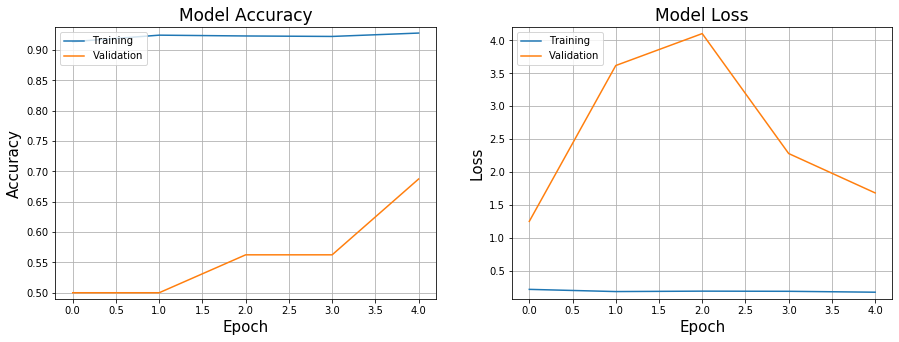

In [462]:
visualize_epochs(history)

## Prediction performance

In [463]:
model = tf.keras.models.load_model(MODEL_FILE)

In [464]:
print("Test dataset results")
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

Test dataset results
1/1 [==============================] - 13s 13s/step - loss: 1.3658 - acc: 0.7276
Loss     : 1.37  
Accuracy : 72.76%
1/1 [==============================] - 14s 14s/step


In [465]:
vl_score = model.predict_generator(test_generator)
AUC = roc_auc_score(test_generator.classes, np.argmax(vl_score, axis=1))

print("-"*35)
print("Confusion Matrix")
print("-"*35)
print(classification_report(test_generator.classes,
                     np.argmax(vl_score, axis=1),
                     target_names=['Normal', 'Pnuemonia']))
print("-"*35)
print("%s%.2f"% ("AUC               : ", AUC))
print("-"*35)

-----------------------------------
Confusion Matrix
-----------------------------------
              precision    recall  f1-score   support

      Normal       0.70      0.48      0.57       234
   Pnuemonia       0.74      0.88      0.80       390

    accuracy                           0.73       624
   macro avg       0.72      0.68      0.68       624
weighted avg       0.72      0.73      0.71       624

-----------------------------------
AUC               : 0.68
-----------------------------------


## Prediction Visualization


#### Random test dataset predictions

In [466]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 72.76%
-----------------------------------


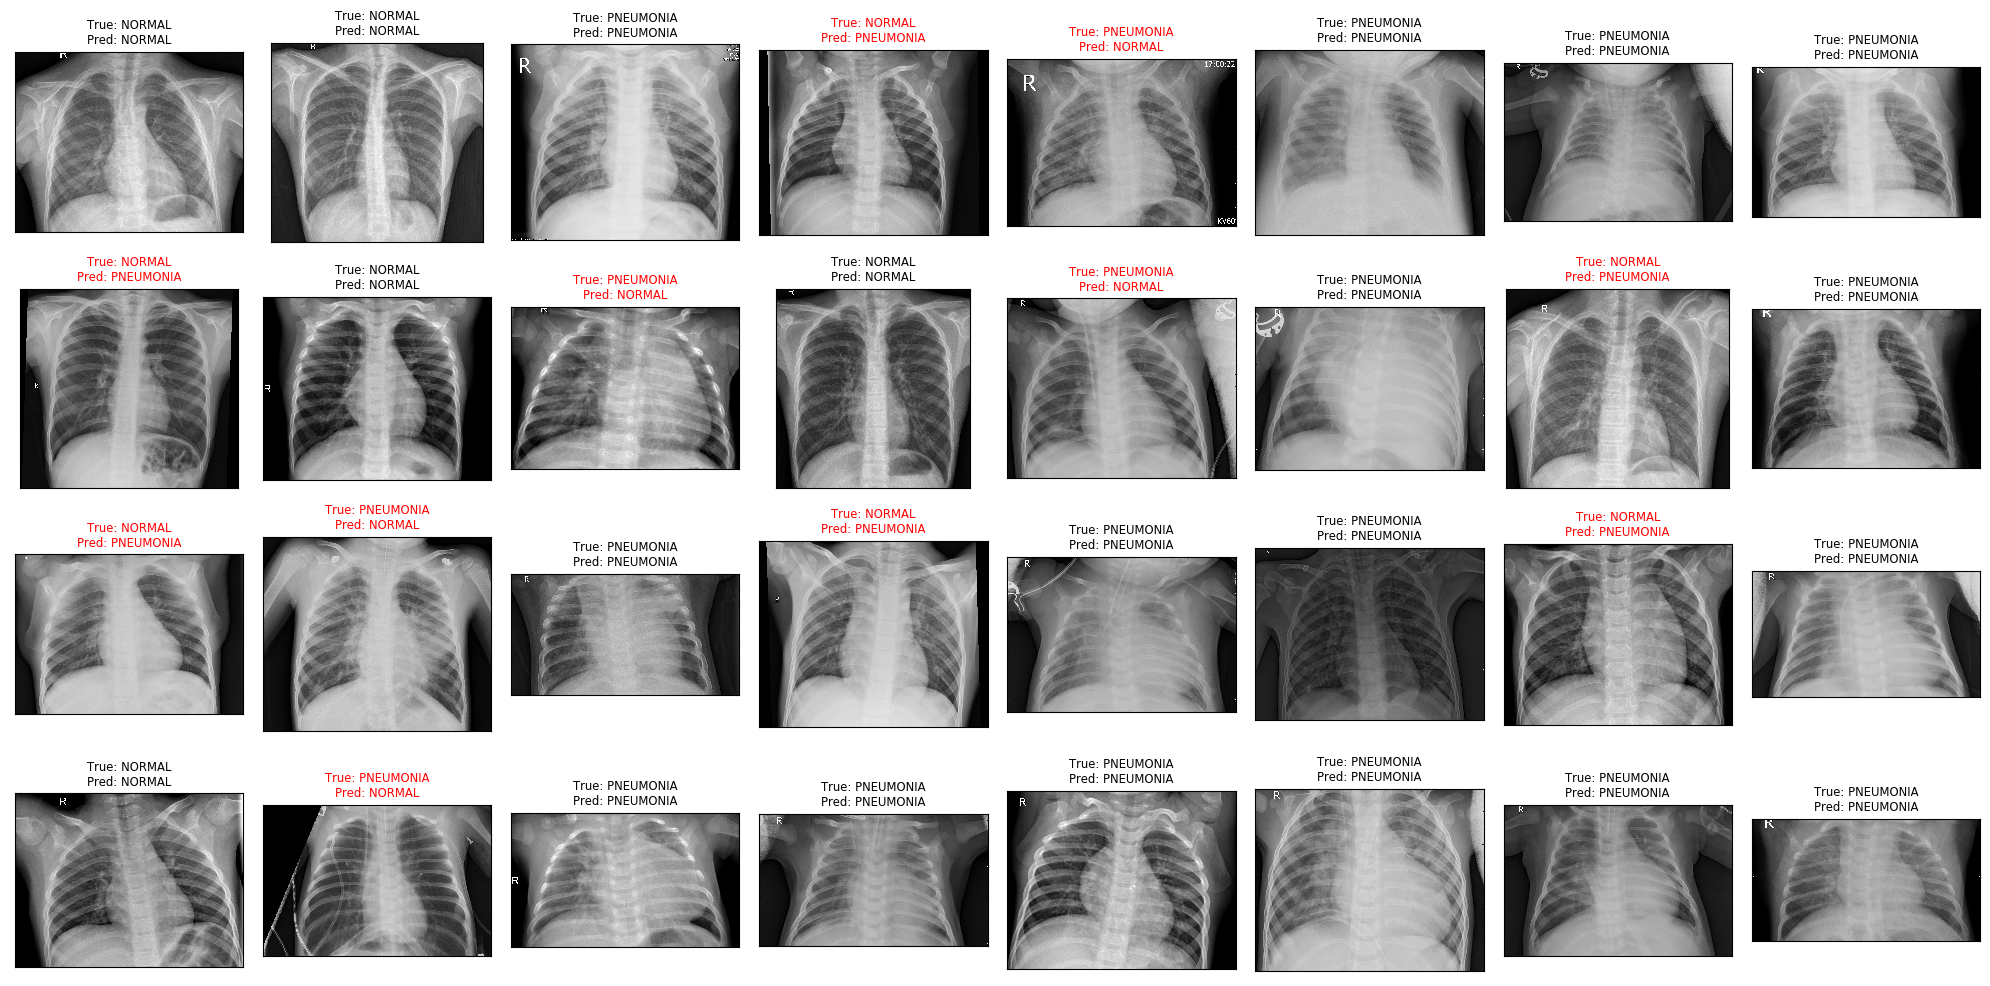

In [467]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, test_dir, image_file_name_batch, count=count, sample=True)

#### Performance on random images from a random batch

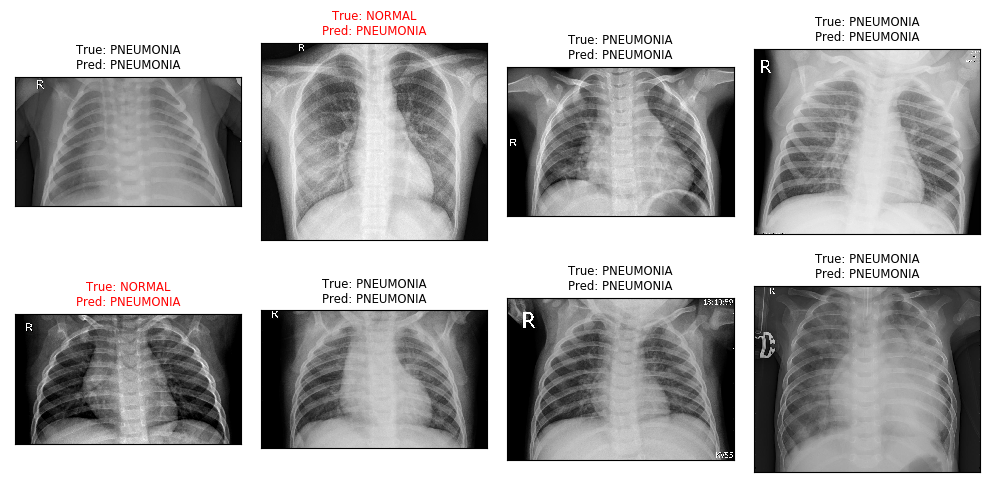

In [468]:
ncols = 4
nrows = 2

if batch_size_t<4:
    cols = 1
    
count = ncols*nrows
    

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()


show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, test_dir, image_file_name_sample, count=count, sample=True)